## 폐렴을 진단해보자

### 데이터셋

캐글의 Chest X-Ray Images

### 폐렴이란?

폐렴은 쉽게 말해 폐에 염증이 생기는 것

### 폐렴 구별법

X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰
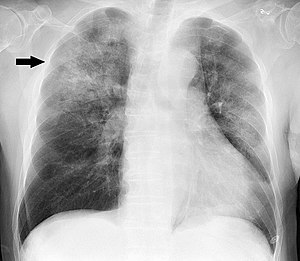

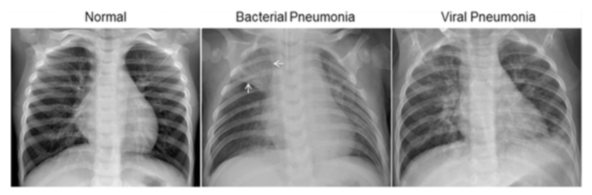
정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐

세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면,

바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴

폐렴에 걸린 사진들은 특징이 패턴을 이루고 있는 것을 볼 수 o

이런 패턴을 잘 읽어내는 딥러닝 알고리즘은 충분히 학습 시킬 수 o

## 1. Set-up

패키지(라이브러리)들을 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

필요한 변수들을 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32 # BATCH_SIZE를 늘려보았다
EPOCHS = 40 # EPOCHS 수도 늘려보았다

print(ROOT_PATH)

/aiffel/aiffel


***
처음 노드의 결과는 accuracy 60%로 좋은 결과는 아니었다..

그리하여 BATCH_SIZE도 16-> 32로 늘리고

EPOCHS도 10 -> 40으로 늘려 진행해보기로 한다!
***

## 2. 데이터 가져오기

아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있다.
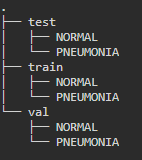

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었다.

***
train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 보기

    ㄴ 정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다. 

또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다.

CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘한다.

train data 클래스 불균형(imbalance) 조정해주기! => 조금 뒤에!

***
tf.data 인스턴스 만들기

mini-batch

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없다.

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수 만들기

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.

이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이기

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경

get_label을 이용해서 라벨 값을 가져오기

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋 만들기

num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


good! 잘 들어가 있다.

train_ds.take(1)은 하나의 데이터만 가져온다는 의미

***
test 데이터셋도 만들기

데이터 개수도 확인

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
***
f.data 파이프라인을 이용하여 **prepare_for_training)** 함수를 정의해서 데이터를 변환
***
**shuffle()** 을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
***
**repeat()** 를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.

    ex) 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.
***    
**batch()** 를 사용하면 BATCH_SIZE에서 정한 만큼의 배치

    ex)  100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 된다.
***    
**prefetch()** 를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

### Augmentation

의료영상의 경우 이미지 회전을 잘 사용한다고 한다.

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training(train_ds)
val_aug_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출

추출된 배치를 image와 label 데이터 셋으로 나누기

show_batch() 함수를 이용해서 결과 사진을 보기

1. Basic

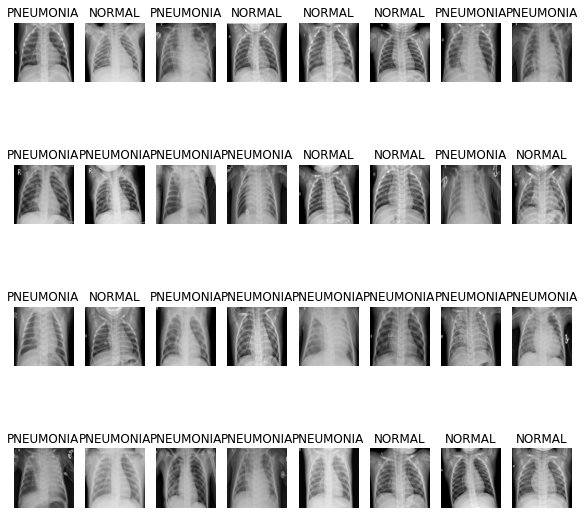

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_basic))
show_batch(image_batch.numpy(), label_batch.numpy())

2. augmentation

(32, 180, 180, 3)
(32,)


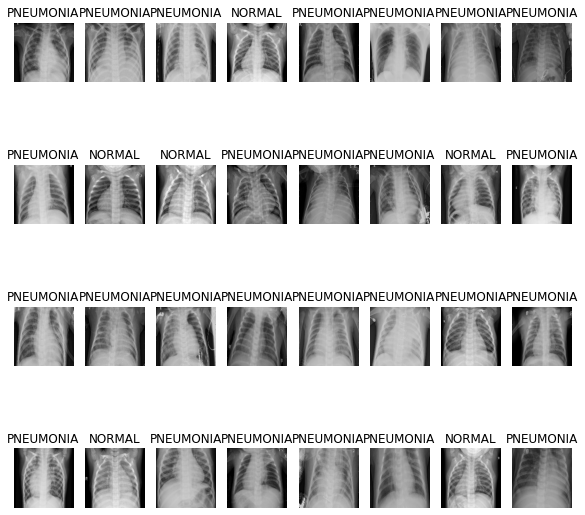

In [17]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_aug_batch, label_aug_batch = next(iter(train_aug_ds))
show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

## 4-1. CNN 모델링

이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보자

먼저, Convolution block을 만들기
***

conv_block()의 구성은 

    Convolution을 두 번 진행하고,

    Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결

    그리고 Max Pooling

In [18]:
def conv_block(filters): # filters가 많을 수록 더 다양한 특징 학습 가능
    block = tf.keras.Sequential([ # 레이어 쌓기
        
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # Separable Convolution은 일반 합성곱과 비슷하지만 
        # 계산 비용을 줄이고 모델 파라미터 수를 감소시키는 효과를 가지며, 
        # 깊이와 공간 방향으로 분리된 합성곱을 수행
        # filters 개수의 필터를 사용하며, 3x3 크기의 커널을 사용
        # 활성화 함수로 'relu'를 사용하며, 
        # 'same' 패딩을 적용하여 입력과 출력의 공간 크기를 동일하게 유지
        
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # 첫 번째 레이어와 동일한 구성
        # 더 복잡한 특징을 추출
        
        tf.keras.layers.BatchNormalization(),
        # 합성곱 레이어 출력의 정규화를 수행
        # 학습을 안정화시키고 학습 속도를 향상시키며, 
        # 그래디언트 소실 또는 폭주 문제를 완화
        
        tf.keras.layers.MaxPool2D()
        # 공간 차원을 다운샘플링하여 특징 맵의 공간 해상도를 줄이는 데 사용
        # 공간적 계층 구조를 만들고 연산 비용을 줄이는 데 도움
    ])
    
    return block

Dense Block 만들기
***

In [19]:
def dense_block(units, dropout_rate): 
    # 인공 신경망의 밀집 연결 층(Dense Layer)으로 구성된 블록을 정의하는 함수
    # 주어진 유닛 수와 드롭아웃 비율을 사용하여 신경망 내에서 밀집 연결 층을 구성하는 역할
    block = tf.keras.Sequential([ # 레이어 쌓기
        tf.keras.layers.Dense(units, activation='relu'),
        # units = 밀집 연결 층(Dense Layer)에서 사용할 유닛(뉴런)의 수
        # 'relu' 활성화 함수를 사용하여 비선형성을 추가
        tf.keras.layers.BatchNormalization(),
        # 밀집 연결 층의 출력을 정규화
        # 학습을 안정화시키고 그래디언트 소실 또는 폭주 문제를 완화시키는 데 도움
        tf.keras.layers.Dropout(dropout_rate)
        # dropdout_rate = 드롭아웃(Dropout)은 과적합을 방지하고 모델의 일반화 성능을 향상시키는 데 사용되는 정규화 기법
        # 드롭아웃을 적용할 때 각 뉴런의 비활성화 확률을 나타냄
        # ex) 드롭아웃 비율이 0.2이면 각 뉴런이 20%의 확률로 비활성화
    ])
    
    return block

전형적인 CNN 모델과는 약간 다른 모델

    방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용
    
    variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝힌 논문도 있다.
    
    그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아니다.
    
    예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있다.

In [20]:
def build_model():
    model = tf.keras.Sequential([ # 레이어 쌓기
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        # 모델의 입력 레이어로, 이미지의 크기와 채널(이 경우 3으로 RGB 이미지)을 지정
        
        # Convolution 레이어
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        # 16개의 필터와 3x3 크기의 커널을 사용하여 합성곱을 수행
        #  'relu' 활성화 함수를 사용하며, 
        # 'same' 패딩을 적용하여 입력과 출력의 공간 크기를 동일하게 유지
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        # 16개의 필터와 3x3 크기의 커널을 사용하여 합성곱을 수행
        #  'relu' 활성화 함수를 사용하며, 
        # 'same' 패딩을 적용하여 입력과 출력의 공간 크기를 동일하게 유지
        
        # Max Pooling 레이어
        tf.keras.layers.MaxPool2D(), 
        # Max Pooling을 사용하여 공간 차원을 다운샘플링하여 공간 해상도를 줄이기
        
        # conv_block 함수
        conv_block(32), 
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #각 블록은 두 번의 Convolution, Batch Normalization, 및 Max Pooling 레이어를 포함
        
        tf.keras.layers.Dropout(0.2),
        # 필터 수가 블록마다 증가하고 드롭아웃 레이어를 추가로 포함
        
        tf.keras.layers.Flatten(),
        # Flatten 레이어는 다차원 특징 맵을 1차원 벡터로 평탄화
        
        # dense_block 함수
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        # 각 블록은 밀집(Dense) 레이어, Batch Normalization, 및 드롭아웃을 포함
        
        tf.keras.layers.Dense(1, activation='sigmoid')
        # 마지막으로, 하나의 뉴런을 가지는 밀집 레이어를 사용하여 모델의 출력을 생성
        # 'sigmoid' 활성화 함수를 사용하여 출력이 이진 분류 작업을 수행하는 확률값으로
    ])
    
    return model

## 4-2. ResNet-18 모델링

**ResNet**의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점

먼저, Residual block 만들기
***

residual block()의 구성은 

    3x3 CNN

    Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결

    그리고 
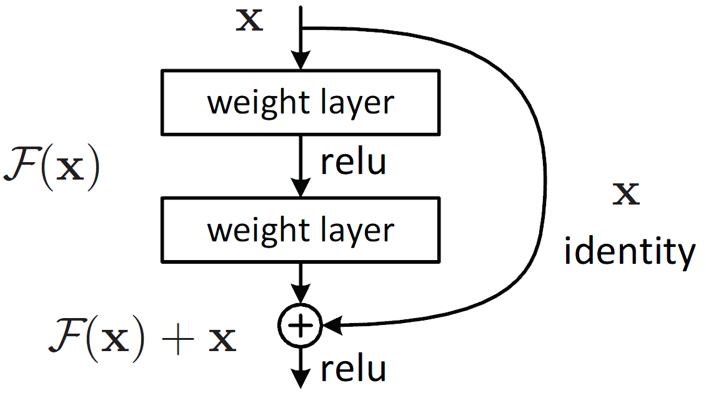

In [38]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Main path => 2개의 합성곱(Conv2D) 레이어, 배치 정규화(BatchNormalization), 활성화 함수(ReLU)로 구성
    x_shortcut = x # 입력 텐서 x를 x_shortcut 변수에 복사, Shortcut 경로에서 사용될 입력 데이터의 복사본을 생성
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x) 
    # 첫 번째 Conv2D 레이어 : 입력 데이터 x에 대해 3x3 커널 크기와 지정된 필터 수(filters)를 사용하여 합성곱을 수행
    x = tf.keras.layers.BatchNormalization()(x)
    # 출력에 배치 정규화를 수행 => 이는 그래디언트 소실 문제를 완화하고 훈련을 안정화시키는 데 도움
    x = tf.keras.layers.Activation('relu')(x)
    # 활성화 함수로 ReLU를 사용하여 비선형성을 추가
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    # 두 번째 Conv2D 레이어
    x = tf.keras.layers.BatchNormalization()(x)
    # 다시 BatchNormalization을 사용하여 출력을 정규화
    
    # Shortcut path => x가 바로 이동
    if stride != 1 or x.shape[-1] != filters:
        x_shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_shortcut) 
        # 입력 데이터의 차원을 주 경로의 출력과 동일하게 만들고
        x_shortcut = tf.keras.layers.BatchNormalization()(x_shortcut)
        # 출력에 배치 정규화를 수행 => 그래디언트 소실 문제를 해결하기 위한 역할
    
    # Add the shortcut to the main path => shortcut경로와 주 경로 결합
    x = tf.keras.layers.Add()([x, x_shortcut])
    # 주 경로의 출력에 Shortcut 경로의 출력을 더하기
    x = tf.keras.layers.Activation('relu')(x)
    # 최종 출력에 ReLU 활성화 함수를 적용하여 비선형성을 추가
    # => 이를 통해 모델은 비선형 관계 학습
    
    return x

In [ ]:
def build_resnet18(input_shape=(180, 180, 3), num_classes=1):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    # 초기 입력 이미지를 처리하는 레이어
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    # Conv2D 레이어 합성곱 진행
    x = tf.keras.layers.BatchNormalization()(x)
    # 배치 정규화를 수행
    x = tf.keras.layers.Activation('relu')(x)
    # 활성화 함수로 ReLU를 사용하여 비선형성을 추가
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    # 공간 차원을 줄인다.
    
    # Residual 블록을 추가
    x = residual_block(x, filters=64, stride=1)
    # 초기 입력 이미지를 유지하기 위해 stride 1
    x = residual_block(x, filters=64, stride=1)
    # 초기 입력 이미지를 유지하기 위해 stride 1
    
    x = residual_block(x, filters=128, stride=2)
    # 이미지의 공간적인 차원을 줄여 더 큰 패턴을 다루기 위해 stride 2
    x = residual_block(x, filters=128, stride=1)
    # 최종 출력 특징 맵의 공간적인 크기를 줄이지 않고 상대적으로 고수준의 특징을 추출
    
    x = residual_block(x, filters=256, stride=2)
    # 이미지의 공간적인 차원을 줄여 더 큰 패턴을 다루기 위해 stride 2
    x = residual_block(x, filters=256, stride=1)
    # 최종 출력 특징 맵의 공간적인 크기를 줄이지 않고 상대적으로 고수준의 특징을 추출
    
    x = residual_block(x, filters=512, stride=2)
    # 이미지의 공간적인 차원을 줄여 더 큰 패턴을 다루기 위해 stride 2
    x = residual_block(x, filters=512, stride=1)
    # 최종 출력 특징 맵의 공간적인 크기를 줄이지 않고 상대적으로 고수준의 특징을 추출
    
    # 필터 수를 64->128->256->512 이렇게 점진적으로 늘리는 것은,
    # => 모델의 표현 능력을 향상시키며, 더 복잡한 데이터에 대한 모델의 표현력을 향상
    
    # Global Average Pooling을 사용하여 출력 크기 조정
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # 네트워크의 출력 크기를 조정
    # 2D 평균을 취하여 텐서의 공간 차원을 제거하고 특징 맵을 벡터로 변환
    
    # 분류를 위한 Fully Connected Layer
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    # num_classes의 수에 따라 출력 뉴런이 설정
    # 활성화 함수로 sigmoid가 사용되어 이진 분류를 위한 확률을 출력
    
    # 모델 생성
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    
    return model

## 5. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많았다.

한 라벨이 너무 많은 경우를 **imbalance** 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.

이런 문제들을 해결하는 방법으로 **Weight balancing**이라는 테크닉이 사용
    
**Weight balancing**

    raining set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
    
    Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅

이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택

모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용

optimizer로 'adam'을 사용 **새로 설정**

성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

***
학습률을 조정하여 다시 훈련을 시켜보자!
***

CNN - 1. basic

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit

각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어주기

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 66s 401ms/step - loss: 0.3438 - accuracy: 0.8310 - precision: 0.9629 - recall: 0.8039 - val_loss: 0.6128 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 51s 391ms/step - loss: 0.1835 - accuracy: 0.9308 - precision: 0.9792 - recall: 0.9266 - val_loss: 0.9030 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/40
130/130 [==============================] - 51s 398ms/step - loss: 0.1551 - accuracy: 0.9425 - precision: 0.9795 - recall: 0.9426 - val_loss: 1.3338 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/40
130/130 [==============================] - 53s 408ms/step - loss: 0.1429 - accuracy: 0.9476 - precision: 0.9832 - recall: 0.9458 - val_loss: 1.7516 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/40
130/130 [==============================] - 54s 415ms/step - loss: 0.1301 - accura

Epoch 37/40
130/130 [==============================] - 48s 368ms/step - loss: 0.0246 - accuracy: 0.9901 - precision: 0.9974 - recall: 0.9893 - val_loss: 0.1455 - val_accuracy: 0.9619 - val_precision: 0.9585 - val_recall: 0.9906
Epoch 38/40
130/130 [==============================] - 47s 362ms/step - loss: 0.0213 - accuracy: 0.9921 - precision: 0.9981 - recall: 0.9913 - val_loss: 0.0625 - val_accuracy: 0.9795 - val_precision: 0.9867 - val_recall: 0.9854
Epoch 39/40
130/130 [==============================] - 47s 360ms/step - loss: 0.0363 - accuracy: 0.9906 - precision: 0.9974 - recall: 0.9900 - val_loss: 0.1133 - val_accuracy: 0.9668 - val_precision: 0.9958 - val_recall: 0.9587
Epoch 40/40
130/130 [==============================] - 47s 365ms/step - loss: 0.0290 - accuracy: 0.9885 - precision: 0.9974 - recall: 0.9871 - val_loss: 0.2887 - val_accuracy: 0.9248 - val_precision: 1.0000 - val_recall: 0.8973


CNN - 2. augmentation

In [24]:
with tf.device('/GPU:0'):
    model_aug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit

각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어주기

In [25]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 61s 395ms/step - loss: 0.4101 - accuracy: 0.7986 - precision: 0.9495 - recall: 0.7704 - val_loss: 0.5975 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 50s 390ms/step - loss: 0.2708 - accuracy: 0.8885 - precision: 0.9672 - recall: 0.8796 - val_loss: 0.6559 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/40
130/130 [==============================] - 51s 392ms/step - loss: 0.2143 - accuracy: 0.9190 - precision: 0.9785 - recall: 0.9113 - val_loss: 0.7412 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/40
130/130 [==============================] - 51s 395ms/step - loss: 0.1792 - accuracy: 0.9332 - precision: 0.9819 - recall: 0.9274 - val_loss: 0.8615 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/40
130/130 [==============================] - 52s 405ms/step - loss: 0.1584 - accura

Epoch 37/40
130/130 [==============================] - 47s 366ms/step - loss: 0.0465 - accuracy: 0.9834 - precision: 0.9967 - recall: 0.9810 - val_loss: 0.4837 - val_accuracy: 0.8389 - val_precision: 0.8195 - val_recall: 1.0000
Epoch 38/40
130/130 [==============================] - 47s 364ms/step - loss: 0.0409 - accuracy: 0.9861 - precision: 0.9974 - recall: 0.9839 - val_loss: 0.0990 - val_accuracy: 0.9639 - val_precision: 0.9749 - val_recall: 0.9762
Epoch 39/40
130/130 [==============================] - 48s 374ms/step - loss: 0.0634 - accuracy: 0.9757 - precision: 0.9941 - recall: 0.9732 - val_loss: 0.0425 - val_accuracy: 0.9844 - val_precision: 0.9986 - val_recall: 0.9800
Epoch 40/40
130/130 [==============================] - 47s 360ms/step - loss: 0.0441 - accuracy: 0.9832 - precision: 0.9944 - recall: 0.9828 - val_loss: 0.1486 - val_accuracy: 0.9482 - val_precision: 0.9986 - val_recall: 0.9307


ResNet - 1. basic

In [42]:
with tf.device('/GPU:0'):
    model_resnet_basic = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_resnet_basic.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit

각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어주기

In [43]:
with tf.device('/GPU:0'):
    history_resnet_basic = model_resnet_basic.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 60s 390ms/step - loss: 0.3337 - accuracy: 0.8858 - precision: 0.9597 - recall: 0.8837 - val_loss: 2.2669 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 48s 373ms/step - loss: 0.1496 - accuracy: 0.9392 - precision: 0.9791 - recall: 0.9384 - val_loss: 0.9662 - val_accuracy: 0.7344 - val_precision: 0.7339 - val_recall: 1.0000
Epoch 3/40
130/130 [==============================] - 49s 380ms/step - loss: 0.1160 - accuracy: 0.9546 - precision: 0.9856 - recall: 0.9528 - val_loss: 0.8419 - val_accuracy: 0.7490 - val_precision: 0.7455 - val_recall: 1.0000
Epoch 4/40
130/130 [==============================] - 49s 380ms/step - loss: 0.0988 - accuracy: 0.9623 - precision: 0.9890 - recall: 0.9600 - val_loss: 8.1247 - val_accuracy: 0.3008 - val_precision: 1.0000 - val_recall: 0.0453
Epoch 5/40
130/130 [==============================] - 50s 384ms/step - loss: 0.0888 - accura

Epoch 37/40
130/130 [==============================] - 46s 357ms/step - loss: 0.0012 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9994 - val_loss: 0.0505 - val_accuracy: 0.9863 - val_precision: 0.9960 - val_recall: 0.9854
Epoch 38/40
130/130 [==============================] - 47s 362ms/step - loss: 0.0014 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9990 - val_loss: 0.1882 - val_accuracy: 0.9561 - val_precision: 0.9457 - val_recall: 0.9973
Epoch 39/40
130/130 [==============================] - 47s 360ms/step - loss: 0.0123 - accuracy: 0.9957 - precision: 0.9984 - recall: 0.9958 - val_loss: 0.1557 - val_accuracy: 0.9600 - val_precision: 0.9958 - val_recall: 0.9493
Epoch 40/40
130/130 [==============================] - 45s 351ms/step - loss: 0.0399 - accuracy: 0.9851 - precision: 0.9944 - recall: 0.9854 - val_loss: 5.1696 - val_accuracy: 0.5674 - val_precision: 1.0000 - val_recall: 0.4109


ResNet - 2. augmentation

In [40]:
with tf.device('/GPU:0'):
    model_resnet = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_resnet.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit

각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어주기

In [41]:
with tf.device('/GPU:0'):
    history_resnet = model_resnet.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 60s 375ms/step - loss: 0.3266 - accuracy: 0.8738 - precision: 0.9593 - recall: 0.8672 - val_loss: 11.6441 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 50s 383ms/step - loss: 0.1868 - accuracy: 0.9327 - precision: 0.9786 - recall: 0.9299 - val_loss: 0.4597 - val_accuracy: 0.8428 - val_precision: 0.8335 - val_recall: 0.9813
Epoch 3/40
130/130 [==============================] - 50s 385ms/step - loss: 0.1403 - accuracy: 0.9466 - precision: 0.9819 - recall: 0.9457 - val_loss: 0.5770 - val_accuracy: 0.8145 - val_precision: 0.7987 - val_recall: 0.9987
Epoch 4/40
130/130 [==============================] - 51s 395ms/step - loss: 0.1179 - accuracy: 0.9541 - precision: 0.9873 - recall: 0.9506 - val_loss: 3.8867 - val_accuracy: 0.3545 - val_precision: 1.0000 - val_recall: 0.1151
Epoch 5/40
130/130 [==============================] - 51s 391ms/step - loss: 0.1059 - accur

Epoch 37/40
130/130 [==============================] - 45s 349ms/step - loss: 0.0153 - accuracy: 0.9935 - precision: 0.9984 - recall: 0.9930 - val_loss: 0.0296 - val_accuracy: 0.9863 - val_precision: 0.9894 - val_recall: 0.9920
Epoch 38/40
130/130 [==============================] - 47s 366ms/step - loss: 0.0119 - accuracy: 0.9959 - precision: 0.9990 - recall: 0.9954 - val_loss: 0.1743 - val_accuracy: 0.9443 - val_precision: 0.9986 - val_recall: 0.9254
Epoch 39/40
130/130 [==============================] - 47s 364ms/step - loss: 0.0116 - accuracy: 0.9950 - precision: 0.9981 - recall: 0.9952 - val_loss: 0.0639 - val_accuracy: 0.9775 - val_precision: 0.9946 - val_recall: 0.9748
Epoch 40/40
130/130 [==============================] - 47s 360ms/step - loss: 0.0235 - accuracy: 0.9918 - precision: 0.9980 - recall: 0.9910 - val_loss: 0.0918 - val_accuracy: 0.9717 - val_precision: 0.9946 - val_recall: 0.9669


## 7. 결과 확인

결과를 확인

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여주기

CNN

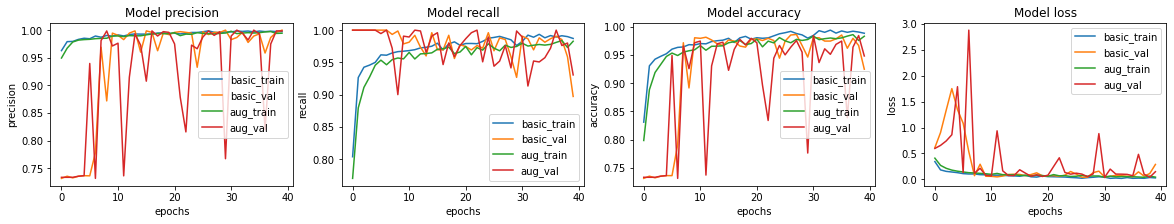

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

테스트 데이터로 모델 평가

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)

20/20 [==============================] - 4s 213ms/step - loss: 0.6224 - accuracy: 0.8830 - precision: 0.8729 - recall: 0.9513


In [31]:
loss, acc, prec, rec = model_aug.evaluate(test_ds)

20/20 [==============================] - 4s 212ms/step - loss: 0.6866 - accuracy: 0.8494 - precision: 0.8203 - recall: 0.9718


Basic:

정확도 (accuracy): 0.8830

정밀도 (precision): 0.8729

재현율 (recall): 0.9513

Augmentation:

정확도 (accuracy): 0.8494

정밀도 (precision): 0.8203

재현율 (recall): 0.9718

Augmentation의 경우 정확도와 정밀도는 떨어졌지만, 재현율은 오른 것을 볼 수 있다.

그래도 첫번째 노드대로 진행했을 때(accuracy = 0.6) 보다는 좋은 결과가 나왔다.

의료 영상의 모델의 특성상 recall도 중요하다.!

***
그래프를 보면, 변동성이 심하다는 것을 볼 수 있다..

Resnet을 이용해서 다시 시도해보자!
***

ResNet

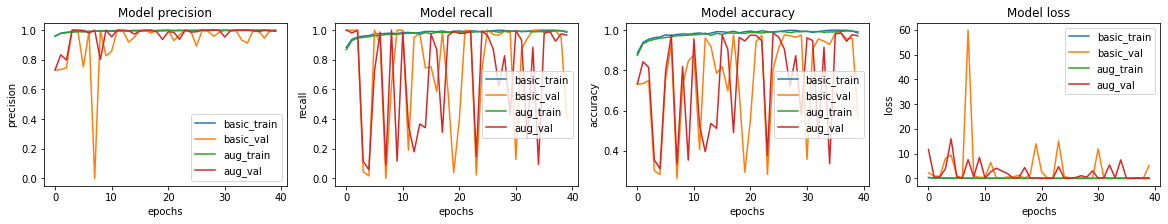

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_resnet_basic.history[met])
    ax[i].plot(history_resnet_basic.history['val_' + met])
    ax[i].plot(history_resnet.history[met])
    ax[i].plot(history_resnet.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

테스트 데이터로 모델 평가

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [46]:
loss, accuracy, precision, recall = model_resnet_basic.evaluate(test_ds)

20/20 [==============================] - 5s 226ms/step - loss: 2.8612 - accuracy: 0.6394 - precision: 0.9024 - recall: 0.4744


In [47]:
loss, accuracy, precision, recall = model_resnet.evaluate(test_ds)

20/20 [==============================] - 4s 203ms/step - loss: 1.4186 - accuracy: 0.7981 - precision: 0.7619 - recall: 0.9846


Basic:

정확도 (accuracy): 0.6394

정밀도 (precision): 0.9024

재현율 (recall): 0.4744

Augmentation:

정확도 (accuracy): 0.7981

정밀도 (precision): 0.7619

재현율 (recall): 0.9846


Resnet의 경우 정확도와 재현율에서는 Augmentation이 좋은 결과를 보이고, 정밀도의 경우 Basic이 더 좋은 결과를 보인다.

훈련 데이터의 경우에는 괜찮지만,,

val 그래프를 보면 recall과 accuracy의 경우 변동성이 더 심해진걸 볼 수 있다..

의료 영상의 모델의 특성상 recall도 중요하기에
recall 결과를 보면,

Resnet Augmentation이 가장 좋은 결과를 나타낸 것을 볼 수 있다.

## 회고
- 배운 점 : Resnet에 대해 배울 수 있었다.
- 아쉬운 점 : 혼자 프로젝트를 해결하려 하다보니 막히는 부분을 해결하는데 어려움이 있었다.
- 느낀 점 : Resnet을 공부하다가 LSTM이 생각났다. 비슷하다는 생각이 들어 찾아보았다.

**Resnet vs LSTM**

Resnet은 CNN과 같이 이미지와 같은 공간적인 데이터를 다루는 데 사용되며,
주로 그래디언트 소실 문제를 해결하기 위한 목적으로 도입된다. 

LSTM은 RNN과 같이 순차적 데이터를 다루는 데 사용되며, 시간적인 순서에 따른 데이터의 패턴 및 의존성을 학습하고 모델링하는 데 중점을 둔다.

요약하면, Resnet은 CNN에서 그래디언트 관련 문제를 해결하고 모델의 학습을 돕는 데 사용되며, 
LSTM은 순차적 데이터를 처리하고 시계열 및 자연어 처리와 같은 응용 분야에서 사용된다.

## 헷갈리는 부분 정리

### 차원 수 vs 차원 크기
***

**차원 수 : 맵의 크기, 채널 수, 필터 수**

=> 합성곱 레이어에서 사용되는 필터 (커널) 수 늘리면 차원 수 증가

=> 맵의 깊이가 늘어나는 효과, 더 복잡한 특징 학습 할 수 o

=> 스트라이드, 패딩은 차원 크기를 줄이고 차원 수를 늘릴 수 o

=> 풀링의 경우 차원을 크기를 줄이고 차원 수를 그대로 유지

=> 차원 수를 늘리면, 더 다양한 특징과 패턴을 인식 할 수 o

ex) 64 -> 128 -> 256 -> 512 ..

**차원 크기 : 맵의 공간 차원(높이와 너비)**

=> 해상도가 높으면 차원 크기는 낮다 (해상도 높으면 더 많은 픽셀로 이루어져있으니까 각 차원의 크기가 커진다)

=> 풀링,  스트라이드 크게하며 다운샘플링 하면 차원 크기 줄어든다.

=> 차원 크기가 줄어들면 더 큰 공간 차원을 가지는 특징 맵

=> 더 큰 공간 차원을 가지는 특징 맵은 더 많은 위치 정보를 포함하며, 공간적 세부 사항을 포착할 수 o 